In [1]:
# %%
# IMPORT LIBRARIES

# GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
    Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
# %%
# PATH & LABEL PROCESS

# Main path
data_path = Path('/Users/macbookpro/Desktop/Brain Tumor Classification')

# Listing subdirectories
file_path = list(data_path.glob('**/*.jpg'))

# Mapping the labels
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

# Transformation to series
files = pd.Series(file_path, name="files", dtype='object').astype(str)
labels = pd.Series(img_labels, name="category", dtype='object')

# Concatenating series to train_data dataframe
train_df = pd.concat([files, labels], axis=1)

# Number of categories
print(train_df['category'].value_counts())
# Shuffling
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Checking results
print(train_df.head())
print(train_df['category'].value_counts())
print(train_df.info())

meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: category, dtype: int64
                                               files          category
0  /Users/macbookpro/Desktop/Brain Tumor Classifi...      glioma_tumor
1  /Users/macbookpro/Desktop/Brain Tumor Classifi...          no_tumor
2  /Users/macbookpro/Desktop/Brain Tumor Classifi...  meningioma_tumor
3  /Users/macbookpro/Desktop/Brain Tumor Classifi...          no_tumor
4  /Users/macbookpro/Desktop/Brain Tumor Classifi...  meningioma_tumor
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: category, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   files     3264 non-null   object
 1   category  3264 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB
None


In [3]:
# %%
# DATA PREPARATION

# Splitting train and test
train_data, test_data = train_test_split(train_df, train_size=0.85, random_state=42)

print("Train shape: ", train_data.shape)
print("Test shape: ", test_data.shape)

print(train_data["category"].value_counts())
print(test_data["category"].value_counts())

# Converting the label to a numeric format
test_images = LabelEncoder().fit_transform(test_data["category"])

Train shape:  (2774, 2)
Test shape:  (490, 2)
meningioma_tumor    791
glioma_tumor        785
pituitary_tumor     770
no_tumor            428
Name: category, dtype: int64
meningioma_tumor    146
glioma_tumor        141
pituitary_tumor     131
no_tumor             72
Name: category, dtype: int64


In [4]:
# %%
# Image generator
train_generator = ImageDataGenerator(rescale=1. / 255,
                                     shear_range=0.3,
                                     zoom_range=0.2,
                                     rotation_range=30,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15)

test_generator = ImageDataGenerator(rescale=1. / 255)

In [5]:
# %%
# Applying generator and transformation to tensor
print("PREPARING THE TRAINING DATA:")
train_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   x_col="files",
                                                   y_col="category",
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=16,
                                                   subset="training")

print("PREPARING THE VALIDATION DATA:")
valid_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   x_col="files",
                                                   y_col="category",
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=16,
                                                   subset="validation")
print("PREPARING THE TEST DATA:")
test_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                 x_col="files",
                                                 y_col="category",
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=16)
train_images.class_indices

PREPARING THE TRAINING DATA:
Found 2358 validated image filenames belonging to 4 classes.
PREPARING THE VALIDATION DATA:
Found 416 validated image filenames belonging to 4 classes.
PREPARING THE TEST DATA:
Found 490 validated image filenames belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [6]:
# %%
# Checking
print("Checking the training data:")
for data_batch, label_batch in train_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

print("Checking the validation data:")
for data_batch, label_batch in valid_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

print("Checking the test data:")
for data_batch, label_batch in test_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the training data:
DATA SHAPE:  (16, 224, 224, 3)
LABEL SHAPE:  (16, 4)
Checking the validation data:
DATA SHAPE:  (16, 224, 224, 3)
LABEL SHAPE:  (16, 4)
Checking the test data:
DATA SHAPE:  (16, 224, 224, 3)
LABEL SHAPE:  (16, 4)


In [7]:
# %%
# EVALUATION AND VISUALIZATION OF MODEL PARAMETERS

def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()


def model_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)
    plt.show()

In [8]:
# %%
# MODEL
from keras.optimizers import *
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
xception = keras.applications.Xception(include_top = False, weights = 'imagenet', input_tensor = None, input_shape = (224,224,3))
x = xception.output
x = Flatten()(x)
output_layer = Dense(4,activation = 'softmax',name = 'softmax')(x)
final_model = keras.Model(inputs = xception.input, outputs = output_layer)
opt = keras.optimizers.Adam(lr = 0.0001)
final_model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
final_model.summary()

Using TensorFlow backend.
2021-10-18 00:17:38.531302: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 00:17:38.531515: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [12]:
final_model.save('Xception_Framework_Model')

In [12]:
# %%
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

history = final_model.fit(train_images,
                    validation_data=valid_images,
                    epochs=5,
                    callbacks=[early_stopping_cb])

Epoch 1/5
148/148 [==============================] - 5271s 36s/step - loss: 0.6562 - accuracy: 0.7362 - val_loss: 1.2104 - val_accuracy: 0.6130
Epoch 2/5
148/148 [==============================] - 4152s 28s/step - loss: 0.3482 - accuracy: 0.8757 - val_loss: 1.4179 - val_accuracy: 0.6779
Epoch 3/5
148/148 [==============================] - 3891s 26s/step - loss: 0.2359 - accuracy: 0.9177 - val_loss: 0.6863 - val_accuracy: 0.7572
Epoch 4/5
148/148 [==============================] - 3960s 27s/step - loss: 0.1999 - accuracy: 0.9321 - val_loss: 0.2735 - val_accuracy: 0.8678
Epoch 5/5
148/148 [==============================] - 3578s 24s/step - loss: 0.1783 - accuracy: 0.9394 - val_loss: 0.0965 - val_accuracy: 0.9519


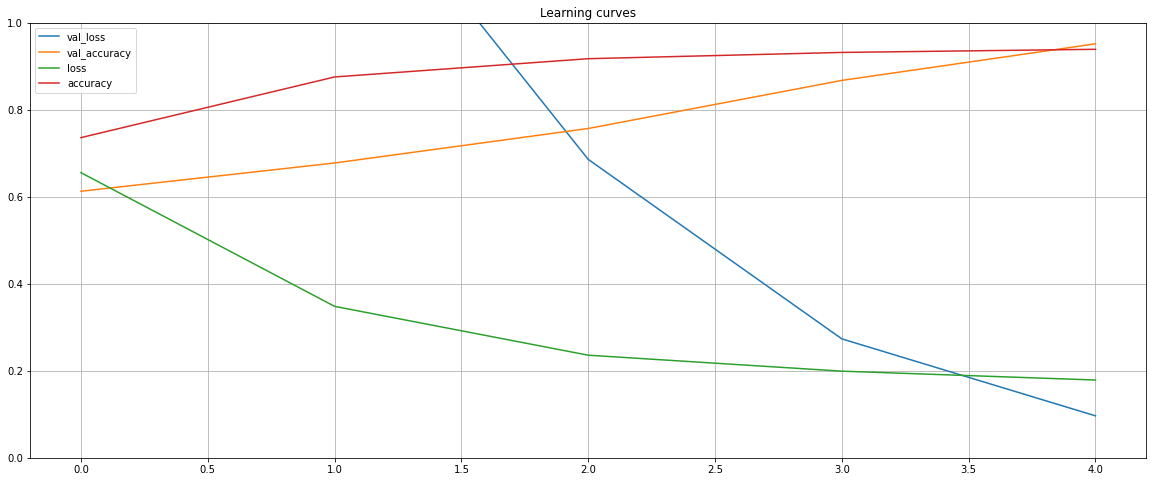

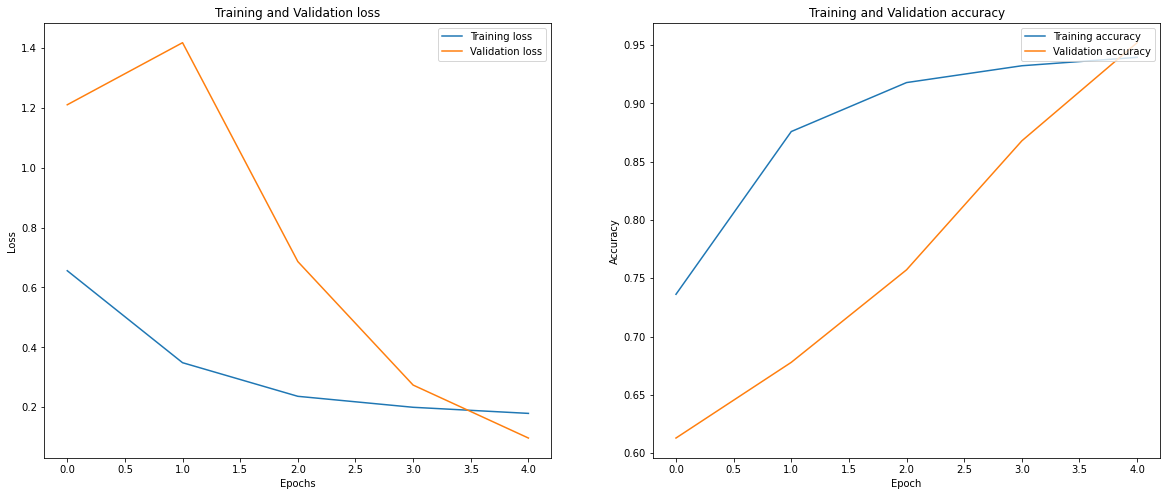

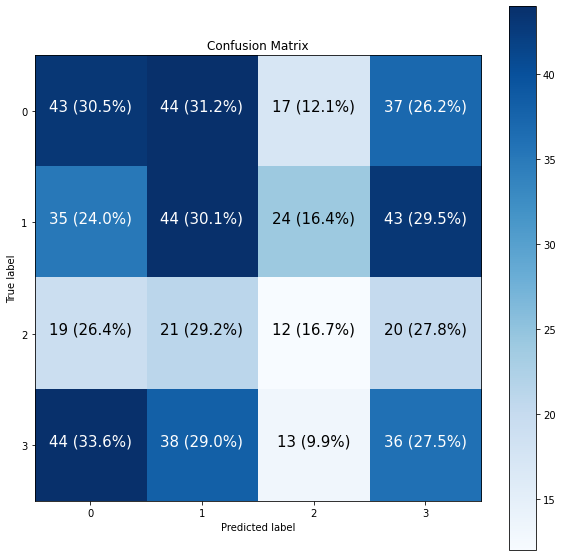

In [13]:
# %%
# EVALUATION RESULT
# Learning curves
learning_curves(history)

# Evaluation model
evaluation_model(history)

# Evaluate the model on the test set
evaluate_1 = final_model.evaluate(test_images, verbose=2)

# Predicting the test set results
y_pred = final_model.predict(test_images)
y_pred_class = np.argmax(y_pred, axis=1)

prediction_class = LabelEncoder().fit_transform(test_data["category"])

# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [9]:
TP=43
TN=44+24+43+21+12+20+38+13+36
FP=44+38+13
FN=44+17+37
acc=(TP+TN)/(FP+FN+TP+TN)

acc=(TP+TN)/(FP+FN+TP+TN)
miss=(FP+FN)/(FP+FN+TP+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
specificity=TN/(TN+FP)
F1_score=2*precision*recall/(precision+recall)

acc=(TP+TN)/(FP+FN+TP+TN)
miss=(FP+FN)/(FP+FN+TP+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
specificity=TN/(TN+FP)
F1_score=2*precision*recall/(precision+recall)

print("Accuracy:")
print(acc)
print("Misclassification Rate:")
print(miss)
print("Precision:")
print(precision)
print("Recall:")
print(recall)
print("specificity:")
print(specificity)
print("F1-Score:")
print(F1_score)

Accuracy:
0.6036960985626283
Misclassification Rate:
0.39630390143737165
Precision:
0.3115942028985507
Recall:
0.3049645390070922
specificity:
0.7254335260115607
F1-Score:
0.30824372759856633
